# 32x32 expGP image reconstruction

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
from torch import nn

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PowerSampler:
    def __init__(self, N, boxlength = 1.0):
        self.N = N
        d = boxlength/N
        freq = torch.fft.fftfreq(N, d=d)
        kx, ky = torch.meshgrid(freq, freq)
        k = (kx**2+ky**2)**0.5
        self.k = k + k[0,1]  # Offset to avoid singularities

    def sample(self, pk):
        N = self.N
        A = torch.randn(N,N)+1j*torch.randn(N,N)  # Random complex amplitudes
        phi_k = A*pk(self.k)**0.5
        phi_x = torch.fft.ifft2(phi_k, norm = 'ortho')
        return phi_x.real

In [3]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = PowerSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.01
        self.sigma[:, :Npix//2] *= 0.1
            
    def build(self, graph):
        theta = graph.node("alpha", self.theta_sampler)
        delta = graph.node("delta", lambda theta: self.powersampler.sample(lambda k: 3*(k/0.5)**-theta[0]), theta)
      #  rho = graph.node("rho", lambda delta: torch.exp(1e2*delta), delta)
     #   x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*0.01, rho)
        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


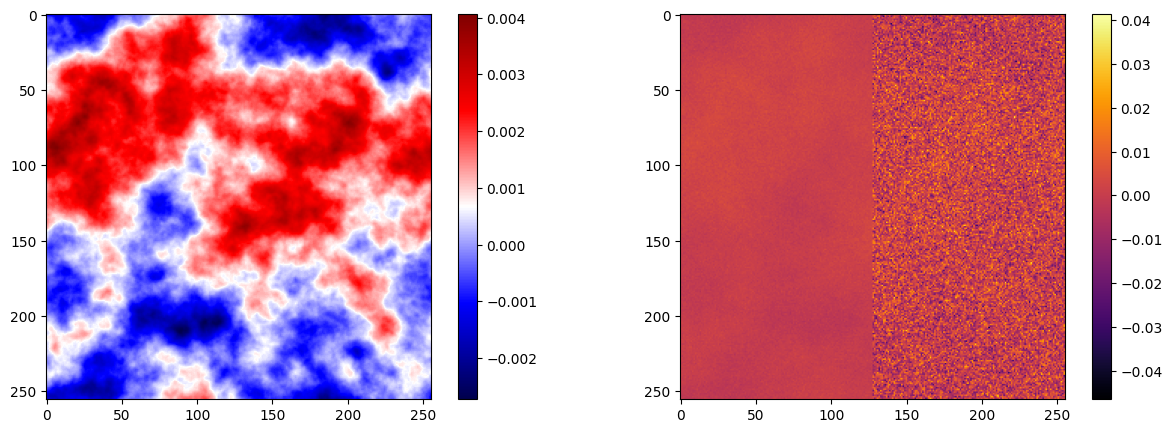

In [4]:
NPIX = 256
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(sample0['delta'], cmap = 'seismic')
plt.colorbar()
plt.subplot(122)
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()

In [5]:
class StrideConv(torch.nn.Module):
    def __init__(self, l_max = 1):
        super().__init__()
        self.convs = torch.nn.ModuleList(
            [torch.nn.Conv2d(1, 1, 3, padding = i, dilation = i, bias = False) 
             for i in [2**l for l in range(l_max)]]
        )
        self.convs_trans = torch.nn.ModuleList(
            [torch.nn.ConvTranspose2d(1, 1, 3, padding = i, dilation = i, bias = False) 
             for i in [2**l for l in range(l_max)]]
        )
    
    def forward(self, x):
        x1 = x.unsqueeze(1)  # B, 1, N, N
        x1 = [conv(x1) for conv in self.convs]
        x1 = sum(x1).squeeze(1)
        return x1*0 + x
    
    def T(self, x):
        x1 = x.unsqueeze(1)  # B, 1, N, N
        for i, conv in enumerate(self.convs):
            self.convs_trans[i].weight = conv.weight
        x1 = [conv(x1) for conv in self.convs_trans]
        x1 = sum(x1).squeeze(1)
        return x1*0 + x

In [6]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x
        self.conv = StrideConv(l_max = 4)
        self.Phi = lambda x: self.conv(x.view(-1, N, N)).view(-1, N*N)
        self.PhiT = lambda x: self.conv.T(x.view(-1, N, N)).view(-1, N*N)
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-3)
        self.l = torch.nn.LazyLinear(1)

    def forward(self, A, B):
        N = self.N
        rhoA = A['x'].view(-1, N**2)
        rhoB = B['x'].view(-1, N**2)
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

In [7]:
sim = SimulatorBlob(Npix = NPIX)
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 478.98it/s]


In [8]:
net = Network(N = NPIX)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 5)
trainer.fit(net, dm)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/cweniger/.pyenv/versions/3.10.11/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` pa

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  88%|███████ | 15/17 [00:02<00:00,  5.17it/s, loss=-5.97e+04, v_num=36]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|███████▌| 16/17 [00:03<00:00,  5.18it/s, loss=-5.97e+04, v_num=36]
Epoch 0: 100%|█| 17/17 [00:03<00:00,  5.27it/s, loss=-5.97e+04, v_num=36, val_lo
Epoch 1:  88%|▉| 15/17 [00:02<00:00,  5.48it/s, loss=-5.93e+04, v_num=36, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  94%|▉| 16/17 [00:02<00:00,  5.50it/s, loss=-5.93e+04, v_num=36, val_lo
Epoch 1: 100%|█| 17/17 [00:03<00:00,  5.57it/s, loss=-5.93e+04, v_num=36, val_lo
Epoch 2:  88%|▉| 15/17 [00:02<00:00,  5.59it/s, loss=-5.93e+04, v_num=36, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  94%|▉| 16/17 [00:02<00:00,  5.66it/s, loss=-5.93e+04, v_num=36, val_lo
Epoch 2: 100%|█| 17/17 [00:02<00:00,  5.76it/s, loss=-5.93e+04, v_num=36, val_lo
Epoch 3:  88%|▉|

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 17/17 [00:02<00:00,  5.76it/s, loss=-5.94e+04, v_num=36, val_lo


In [10]:
net.cuda()
net.double()
x = sample0['x']
x = torch.tensor(x).flatten().double().cuda()
G1Tt, D1, G1t, b = net.lre.get_likelihood_components(x)
#D1.max(), D1.min()
#plt.imshow(D1.detach().cpu().view(NPIX, NPIX))
#plt.colorbar()
#D1[D1>50000] = 20
#D1[D1<50000] = 20
#D1[:] = 50000
G1T = lambda x: G1Tt(x.unsqueeze(0))[0]
G1 = lambda x: G1t(x.unsqueeze(0))[0]
#def G1(x):
#    y = G1t(x)
#    z = x.double()# + y.detach().double()*0
#    print(z.shape, z.device, z.dtype)
#    return z
#(G1T(x) - x).max()

In [11]:
k = PowerSampler(NPIX).k
D2 = 3*(k/0.5)**-4.
D2 = D2.view(-1).double().cuda()

In [13]:
#plt.imshow(B)

In [14]:
N = NPIX
U2 = lambda x: torch.fft.fft2(x.view(N, N), norm = 'ortho').view(N*N)
U2T = lambda x: torch.fft.ifft2(x.view(N, N), norm = 'ortho').view(N*N)
geda = swyft.utils.GEDASampler(1e-5, G1, D1, G1T, U2, 1/D2, U2T)

In [15]:
x = geda.sample(16, steps = 100)

In [16]:
#plt.plot([x[i].view(N, N)[:,:].mean().cpu().detach() for i in range(len(x))])
#plt.plot([x[i].view(N, N)[:,:32].mean().cpu().detach() for i in range(len(x))])
#plt.plot([x[i].view(N, N)[:,32:].mean().cpu().detach() for i in range(len(x))])

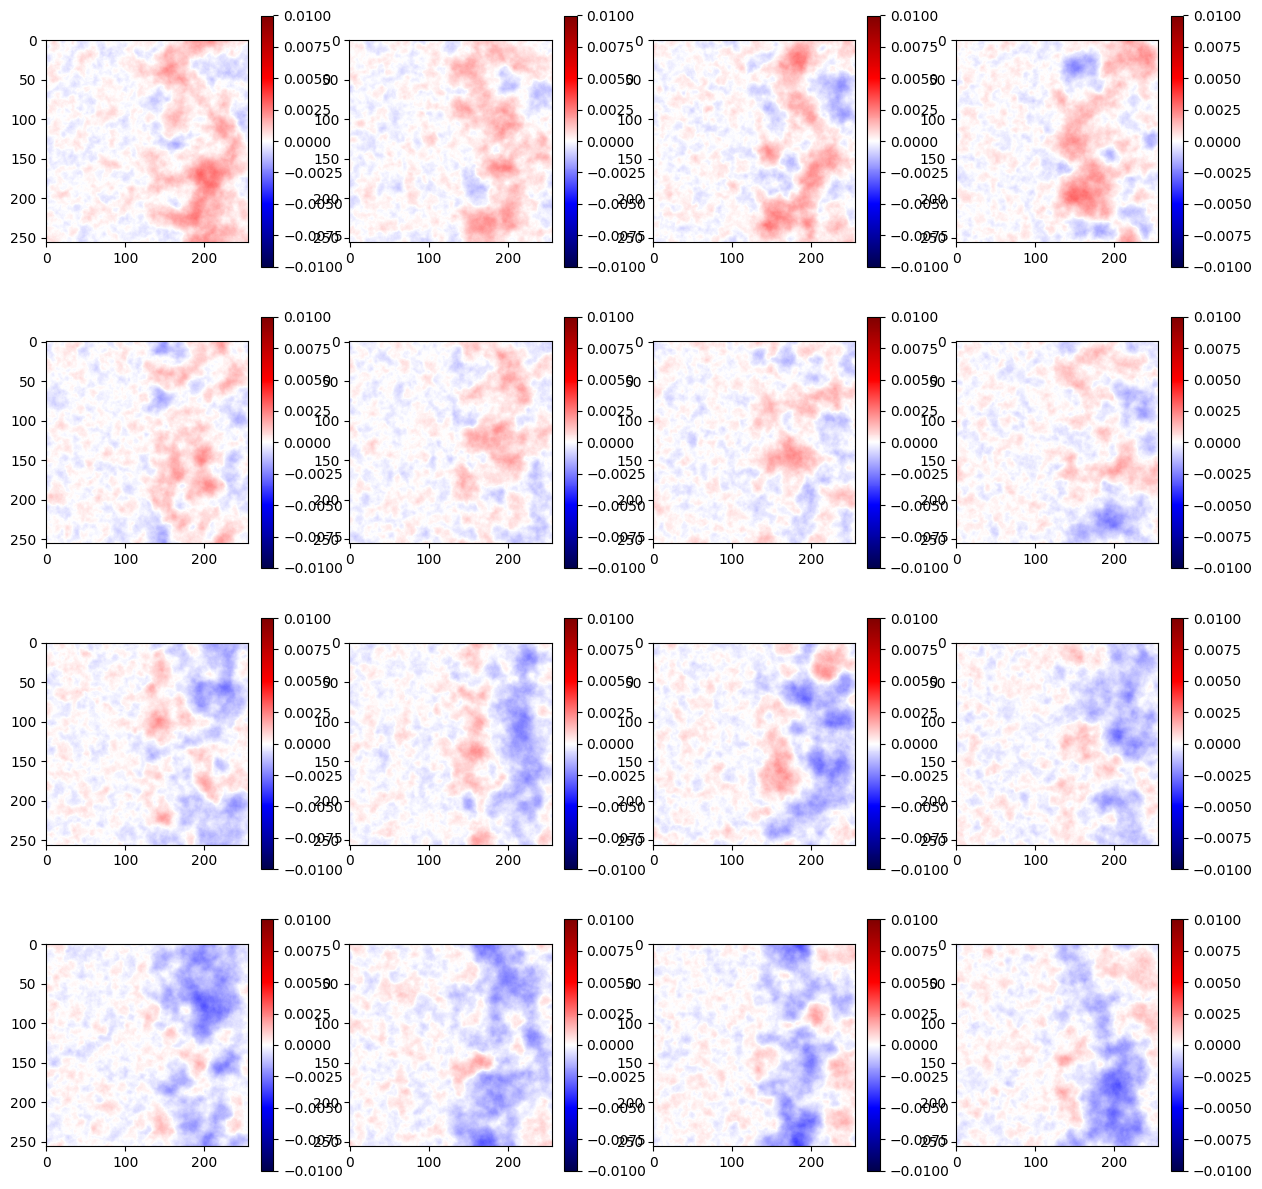

In [17]:
plt.figure(figsize = (15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    v = torch.abs(x[i]).max()
    v = 0.01
    plt.imshow(x[i].view(N, N).cpu(), vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()